# Main imports and code - Preparation

In [1]:
# check which gpu we're using
!nvidia-smi

Mon Mar  4 21:48:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install simpletransformers
!pip install tensorboardx
!pip install googletrans
!pip install nltk
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.

In [3]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [4]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [5]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Fetch Don't Patronize Me! data manager module

In [6]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [7]:
#the raw dataset
!wget -O dontpatronizeme_pcl.tsv https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv

--2024-03-04 21:49:41--  https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122842 (3.0M) [text/plain]
Saving to: ‘dontpatronizeme_pcl.tsv’

dontpatronizeme_pcl 100%[===================>]   2.98M  --.-KB/s    in 0.01s   

2024-03-04 21:49:42 (220 MB/s) - ‘dontpatronizeme_pcl.tsv’ saved [3122842/3122842]



In [8]:
# their training selection set - i assume it's for picking up corresponding id from the raw dataset
!wget -O train_semeval_parids-labels.csv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv

--2024-03-04 21:49:42--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241839 (236K) [text/plain]
Saving to: ‘train_semeval_parids-labels.csv’

train_semeval_parid 100%[===================>] 236.17K  --.-KB/s    in 0.004s  

2024-03-04 21:49:42 (60.3 MB/s) - ‘train_semeval_parids-labels.csv’ saved [241839/241839]



In [9]:
#their testing selection set
!wget -O dev_semeval_parids-labels.csv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv

--2024-03-04 21:49:42--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61151 (60K) [text/plain]
Saving to: ‘dev_semeval_parids-labels.csv’

dev_semeval_parids- 100%[===================>]  59.72K  --.-KB/s    in 0.001s  

2024-03-04 21:49:42 (79.8 MB/s) - ‘dev_semeval_parids-labels.csv’ saved [61151/61151]



In [10]:
#testing set
!wget -O task4_test.tsv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv

--2024-03-04 21:49:42--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145277 (1.1M) [text/plain]
Saving to: ‘task4_test.tsv’

task4_test.tsv      100%[===================>]   1.09M  --.-KB/s    in 0.008s  

2024-03-04 21:49:43 (143 MB/s) - ‘task4_test.tsv’ saved [1145277/1145277]



In [11]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [12]:
from dont_patronize_me import DontPatronizeMe

In [13]:
dpm = DontPatronizeMe('.', 'task4_test.tsv')

In [14]:
dpm.load_task1()
#Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
#Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.

## Load paragraph IDs

In [15]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [16]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [17]:
data=dpm.train_task1_df

In [18]:
data


,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [19]:
data = data.dropna()

# RAW Dataset - Q1.a & b Data Analysis Code - SAVE FOR MICHAEL

In [20]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# label_distribution = data['label'].value_counts()
# label_distribution.index = label_distribution.index.astype(str)
# orig_label_distribution = data['orig_label'].value_counts()
# total = label_distribution.sum()

# # distribution of 'label'
# plt.figure(figsize=(3.5, 0.75))
# barplot = sns.barplot(x=label_distribution.values, y=label_distribution.index, orient='h', color='lightblue')
# plt.title('')
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks([])
# for p in barplot.patches:
#     width = p.get_width()
#     count = int(width)
#     percentage = f"({count / total:.1%})"
#     plt.text(width + 1, p.get_y() + p.get_height() / 2, f"{count} {percentage}", ha='left', va='center', color='black')
# for spine in plt.gca().spines.values():
#     spine.set_visible(False)
# plt.gca().tick_params(left=False)  # Remove y-axis tick marks
# plt.tight_layout()  # Adjust the layout to make sure everything fits without overlapping
# plt.savefig('distribution_of_pcl.pdf', format='pdf', bbox_inches='tight')  # Save the figure as a PDF
# plt.show()

# # distribution of 'orig_label'
# agg_data = data.groupby('orig_label').agg(
#     count=('orig_label', 'size'),
#     most_common_label=('label', lambda x: x.mode()[0])
# ).reset_index()
# agg_data['label_group'] = agg_data['most_common_label'].map({0: 'No PCL', 1: 'PCL'})
# color_map = {'No PCL': 'lightblue', 'PCL': 'salmon'}
# plt.figure(figsize=(3.5, 3.5))
# sns.barplot(x='orig_label', y='count', hue='label_group', dodge=False,
#             palette=color_map, data=agg_data)
# plt.title('Distribution of Original Labels')
# plt.xlabel('Original Label')
# plt.ylabel('')
# legend = plt.legend(title='')
# for spine in plt.gca().spines.values():
#     spine.set_visible(False)
# plt.tick_params(axis='x', which='both', bottom=False, top=False)
# legend.get_frame().set_edgecolor('none')  # This removes the border
# plt.tight_layout()
# plt.savefig('distribution_of_orig_labels_by_group.pdf', format='pdf', bbox_inches='tight')
# plt.show()

# # PCL by vulnerable group
# keyword_label_counts = data.groupby(['keyword', 'label']).size().unstack(fill_value=0)
# keyword_label_proportions = keyword_label_counts.div(keyword_label_counts.sum(axis=1), axis=0)
# keyword_label_proportions.reset_index(inplace=True)
# fig, ax = plt.subplots(figsize=(3.5, 2.75))
# ax.barh(keyword_label_proportions['keyword'], keyword_label_proportions[0], label='No PCL', color='lightblue')
# ax.barh(keyword_label_proportions['keyword'], keyword_label_proportions[1], left=keyword_label_proportions[0], label='PCL', color='salmon')
# ax.set_ylabel('')
# ax.set_xlabel('Proportion')
# ax.set_title('')
# ax.tick_params(axis='y', which='both', left=False)  # Remove y-axis tick marks
# legend = ax.legend(title='', loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2)
# legend.get_frame().set_linewidth(0.0)  # Remove the legend border
# for spine in ax.spines.values():
#     spine.set_visible(False)
# plt.tight_layout()
# plt.savefig('pcl_by_keyword.pdf', format='pdf', bbox_inches='tight')
# plt.show()

# # Box plot of paragraph length by PCL label
# data['text_length'] = data['text'].apply(len)
# data['label_str'] = data['label'].map({0: 'No PCL', 1: 'PCL'})
# palette_colors = {'No PCL': 'lightblue', 'PCL': 'salmon'}
# plt.figure(figsize=(3.5, 2.75))  # Adjust the figure size as needed
# ax = sns.boxplot(x='text_length', y='label_str', hue='label_str', data=data, orient='h',
#                  palette={'No PCL': 'lightblue', 'PCL': 'salmon'}, dodge=False, legend=False)
# plt.title('')
# plt.xlabel('Text length')
# plt.ylabel('')
# for spine in ax.spines.values():
#     spine.set_visible(False)
# ax.set_xlim(0, 2000)
# ax.tick_params(axis='y', which='both', left=False)  # Remove y-axis tick marks
# plt.tight_layout()
# plt.savefig('pcl_by_length.pdf', format='pdf', bbox_inches='tight')
# plt.show()



## Get the raw training set (Task 1) - without split

In [21]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [22]:
import random

In [23]:
trdf1 = pd.DataFrame(rows)

In [24]:
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [25]:
trdf1.to_csv("trdf1.csv")

## get the raw test set (Task 1)

In [26]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [27]:
len(rows)

2094

In [28]:
tedf1 = pd.DataFrame(rows)
#print(tedf1)

In [29]:
random.shuffle(tedf1.text.tolist())
tedf1.to_csv("tedf1.csv")
#shuffled_tedf1 = tedf1.sample(frac=1).reset_index(drop=True)

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


def evaluate_model(true_labels, preds):
    f1 = f1_score(true_labels, preds)
    accuracy = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    conf_matrix = confusion_matrix(true_labels, preds)
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


    print("Confusion Matrix:")
    print(conf_matrix)



## Baseline for Task 1

In [31]:
print(len(trdf1[trdf1.label==0]))
print(len(trdf1[trdf1.label==1]))
print((len(trdf1[trdf1.label==0]))/len(trdf1[trdf1.label==1]))

7581
794
9.547858942065492


Neg is 10 times more than positive class.

### RoBERTa Negative : Positive = 2:1

- non-pcl : pcl = 2:1
- 46.7% F1 on offical dev set

In [32]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)
#0, limited to twice the number of positive examples
training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [33]:
# from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs

# results = []

# for seed in [random.randint(1, 100) for _ in range(10)]:
#     for base in ['roberta', 'deberta']:
#         baseline = base

#         task1_model_args = ClassificationArgs(num_train_epochs=1,
#                                             no_save=True,
#                                             no_cache=True,
#                                             manual_seed = seed,
#                                             overwrite_output_dir=True,
#                                             use_multiprocessing=False,
#                                             use_multiprocessing_for_evaluation=False)
#         if baseline == 'roberta':
#             task1_model = ClassificationModel("roberta",
#                                             'roberta-base',
#                                             args = task1_model_args,
#                                             num_labels=2,
#                                             use_cuda=cuda_available)
#         elif baseline == 'deberta':
#             task1_model = ClassificationModel("deberta",
#                                             'microsoft/deberta-base',
#                                             args = task1_model_args,
#                                             num_labels=2,
#                                             use_cuda=cuda_available)
#         else:
#             print("Please enter valid model to take as a baseline")
#         task1_model.train_model(training_set1[['text', 'label']])
#         preds_task1, _ = task1_model.predict(tedf1.text.tolist())
#         true_labels = tedf1.label.tolist()
#         f1 = f1_score(true_labels, preds_task1)
#         results_tuple = (base, seed, f1)
#         results.append(results_tuple)
# results = pd.DataFrame(results, columns=['Model', 'Seed', 'F1'])
# Creating boxplot
# plt.figure(figsize=(3.5, 2.75))
# ax = sns.boxplot(x='F1', y='Model', hue='Model', data=results, dodge=False, legend=False,
#             palette={'roberta': 'lightblue', 'deberta': 'salmon'})
# plt.title('')
# plt.xlabel('F1 Score')
# plt.ylabel('')
# plt.tight_layout()
# for spine in ax.spines.values():
#     spine.set_visible(False)
# ax.tick_params(axis='y', which='both', left=False)  # Remove y-axis tick marks
# plt.savefig('avg_berta_performance.pdf', format='pdf', bbox_inches='tight')
# plt.show()
# torch.cuda.memory_allocated()
# torch.cuda.empty_cache()
# del task1_model
# del preds_task1
# del true_labels
# torch.cuda.memory_allocated()

### <strike>{RoBERTa Negative : Positive = 3:1}</strike>
- change ratio to 3:1
- F1: 52.21%

In [34]:
# training_set2 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*3]])

# # train model
# task1_model.train_model(training_set2[['text', 'label']])
# # run predictions
# preds_task1, _ = task1_model.predict(tedf1.text.tolist())
# true_labels = tedf1.label.tolist()
# evaluate_model(true_labels, preds_task1)

# Get Train + Val + Test Set

In [35]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(trdf1, test_size=0.2, random_state=905)
test_set = tedf1

In [36]:
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(6700, 4)
(1675, 4)
(2094, 4)


In [37]:
# model_args = ClassificationArgs(
#           num_train_epochs = 4,
#           learning_rate = 2e-5,
#           overwrite_output_dir = True,
#           evaluate_during_training = True,
#           manual_seed = 42,
#           use_early_stopping = True,
#           early_stopping_consider_epochs = True,
#           early_stopping_patience = 3,
#           save_steps = -1 , # Save the model only at the end of training
#           train_batch_size = 16,
#           eval_batch_size = 8
# )


# model = ClassificationModel('electra', 'google/electra-small-discriminator', args=model_args,num_labels=2,
#                                   use_cuda=cuda_available)


# model.train_model(train_set[['text', 'label']], eval_df = val_set[['text', 'label']])

# predictions, raw_outputs = model.predict(test_set['text'].tolist())
# evaluate_model(test_set['label'].tolist(),predictions )

# Q2.c & e

## Data Sampling to traning set

- downsampling Majority & Upsampling Minoriry
- For the sake of more training data, i choose upsampled dataset as the traning one.

In [38]:
majority_class_df = train_set[train_set['label'] == 0]
minority_class_df = train_set[train_set['label'] == 1]

majority_class_sampled = majority_class_df.sample(n=len(minority_class_df), random_state=42)
minority_class_sampled = minority_class_df.sample(n=len(majority_class_df), random_state=42, replace=True)

balanced_df_down = pd.concat([majority_class_sampled, minority_class_df])

balanced_df_up = pd.concat([minority_class_sampled, majority_class_df])

balanced_df_down = balanced_df_down.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df_up = balanced_df_up.sample(frac=1, random_state=42).reset_index(drop=True)

In [39]:
print(majority_class_sampled.shape)
print(minority_class_sampled.shape)
print(balanced_df_down.shape)
print(balanced_df_up.shape)

print(balanced_df_up['label'].value_counts())
print(balanced_df_down['label'].value_counts())

(625, 4)
(6075, 4)
(1250, 4)
(12150, 4)
0    6075
1    6075
Name: label, dtype: int64
1    625
0    625
Name: label, dtype: int64


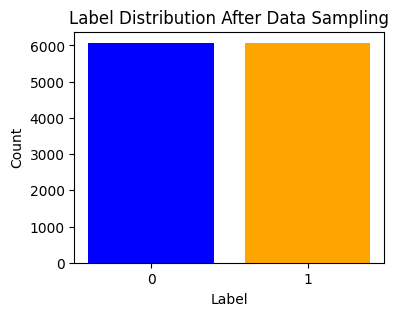

In [42]:
import matplotlib.pyplot as plt
labels = balanced_df_up['label'].value_counts().index
counts = balanced_df_up['label'].value_counts().values

plt.figure(figsize=(4, 3))
plt.bar(labels, counts, color=['blue', 'orange']) # Corrected line
plt.title('Label Distribution After Data Sampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(labels)
plt.show()

In [44]:

val_set_processed = val_set


In [45]:
new_train_set_processed = balanced_df_up
val_set_processed
test_set

,par_id,community,text,label
0,4046,hopeless,We also know that they can benefit by receivin...,1
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1
...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0


### Deberta after sampling

In [46]:
# torch.cuda.memory_allocated()
# torch.cuda.empty_cache()
# del deberta_model
# del predictions_deberta
# torch.cuda.memory_allocated()

In [48]:
deberta_model_args = ClassificationArgs(
    num_train_epochs = 4,
    learning_rate=2e-5,
    overwrite_output_dir=True,
    evaluate_during_training=True,
    manual_seed=42,
    use_early_stopping=True,
    early_stopping_consider_epochs=True,
    early_stopping_patience=3,
    save_steps=-1,  # Save the model only at the end of training
    train_batch_size=32,
    eval_batch_size=16,
)

deberta_model = ClassificationModel(
    'deberta',
    'microsoft/deberta-base',
    args=deberta_model_args,
    num_labels=2,
    use_cuda=cuda_available
    )


deberta_model.train_model(new_train_set_processed[['text', 'label']], eval_df=val_set[['text', 'label']])


result, model_outputs, wrong_predictions = deberta_model.eval_model(val_set[['text', 'label']])


print(result)

predictions_deberta, raw_outputs = deberta_model.predict(test_set['text'].tolist())
evaluate_model(test_set['label'].tolist(),predictions_deberta )


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/380 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/380 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/380 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/380 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

{'mcc': 0.49535486654427896, 'accuracy': 0.9229850746268656, 'f1_score': 0.5095057034220533, 'tp': 67, 'tn': 1479, 'fp': 27, 'fn': 102, 'auroc': 0.8300663224812782, 'auprc': 0.5440996365921236, 'eval_loss': 0.6442004969449564}


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

F1 Score: 0.5167173252279635
Accuracy: 0.9240687679083095
Precision: 0.6538461538461539
Recall: 0.4271356783919598
Confusion Matrix:
[[1850   45]
 [ 114   85]]


### BOW after sampling
tokenize words of length 3 to 10, use unigrams (ngram_range=(1, 1)), limit the features to the 23,000 most frequent words, and exclude English stop words.

Training: The Logistic Regression model is trained with a very high regularization strength (C=1500) and a high iteration limit to ensure convergence.

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
#reference: https://www.kaggle.com/code/ziedbaklouti/bow-logistic-regression-sklearn?scriptVersionId=33955168&cellId=5

# Preprocess and Vectorize Text Data
vect1 = CountVectorizer(token_pattern=r'\w{3,10}', ngram_range=(1, 1),
                        max_features=23000, stop_words='english')

# Fit the vectorizer on the training data and transform the training data
X_train_vect = vect1.fit_transform(new_train_set_processed['text'])
# Transform the val data
X_val_vect = vect1.transform(val_set_processed['text'])

#Train a Logistic Regression Model
log_reg1 = LogisticRegression(C=1500, max_iter=10000)

# Fit the model on the vectorized training data
log_reg1.fit(X_train_vect, new_train_set_processed['label'])

#Make Predictions and Evaluate the Model
y_predicted_val = log_reg1.predict(X_val_vect)
print('------Val Set--------------')
evaluate_model(val_set_processed['label'],y_predicted_val)

# Transform the test data
print('------Test Set--------------')
X_test_vect = vect1.transform(test_set['text'])
y_predicted_test = log_reg1.predict(X_test_vect)
evaluate_model(test_set['label'],y_predicted_test)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neverthele'] not in stop_words.
  warnings.warn(


------Val Set--------------
F1 Score: 0.2935153583617747
Accuracy: 0.8764179104477612
Precision: 0.3467741935483871
Recall: 0.25443786982248523
Confusion Matrix:
[[1425   81]
 [ 126   43]]
------Test Set--------------
F1 Score: 0.2893401015228427
Accuracy: 0.8662846227316141
Precision: 0.2923076923076923
Recall: 0.2864321608040201
Confusion Matrix:
[[1757  138]
 [ 142   57]]


In [52]:
import numpy as np
misclassified_indices = np.where(y_predicted_val != val_set_processed['label'])[0]

# first misclassified example
if len(misclassified_indices) > 0:
    example_index = misclassified_indices[0]
    misclassified_text = val_set_processed['text'].iloc[example_index]
    true_label = val_set_processed['label'].iloc[example_index]
    predicted_label = y_predicted_val[example_index]

    print("Example of Misclassified Text:")
    print(f"Text: {misclassified_text}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
else:
    print("No misclassified examples found.")


Example of Misclassified Text:
Text: """ Every family which qualifies for the program should be covered . Every child in poor families must be placed and kept in school , and they should enjoy health and nutrition assistance , Romualdez said ."
True Label: 1, Predicted Label: 0


### TD-IDF after after sampling

uses unigrams (ngram_range=(1, 1)), which may not capture the sentiment expressed through phrases.

Max Features Limitation: Limiting to 1000 max features

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess and Vectorize Text Data using TF-IDF
vect1 = TfidfVectorizer(ngram_range=(1, 1),max_features=1000, stop_words='english').fit(train_set.text)

# Fit the vectorizer on the training data and transform the training data
X_train_vect = vect1.fit_transform(new_train_set_processed['text'])
# Transform the validation data
X_val_vect = vect1.transform(val_set_processed['text'])

# Train a Logistic Regression Model
log_reg1 = LogisticRegression(C=1500, max_iter=10000)

# Fit the model on the vectorized training data
log_reg1.fit(X_train_vect, new_train_set_processed['label'])
print('------Val Set--------------')
# Make Predictions and Evaluate the Model on the validation set
y_predicted_val = log_reg1.predict(X_val_vect)
evaluate_model(val_set_processed['label'],y_predicted_val)
print('------Test Set--------------')

X_test_vect = vect1.transform(test_set['text'])
y_predicted_test = log_reg1.predict(X_test_vect)
evaluate_model(test_set['label'],y_predicted_test)

------Val Set--------------
F1 Score: 0.33986928104575165
Accuracy: 0.8191044776119403
Precision: 0.2689655172413793
Recall: 0.46153846153846156
Confusion Matrix:
[[1294  212]
 [  91   78]]
------Test Set--------------
F1 Score: 0.31669535283993117
Accuracy: 0.8104106972301814
Precision: 0.24083769633507854
Recall: 0.4623115577889447
Confusion Matrix:
[[1605  290]
 [ 107   92]]


In [54]:
import numpy as np

# Identifying indices of misclassified examples in the validation set
misclassified_indices_val = np.where(y_predicted_val != val_set_processed['label'])[0]

if len(misclassified_indices_val) > 0:
    example_index_val = misclassified_indices_val[0]  # Just choose the first misclassified example for analysis
    misclassified_text_val = val_set_processed['text'].iloc[example_index_val]
    true_label_val = val_set_processed['label'].iloc[example_index_val]
    predicted_label_val = y_predicted_val[example_index_val]

    print("Example of Misclassified Text in Validation Set:")
    print(f"Text: {misclassified_text_val}")
    print(f"True Label: {true_label_val}, Predicted Label: {predicted_label_val}")
else:
    print("No misclassified examples found in the validation set.")


Example of Misclassified Text in Validation Set:
Text: As a result , millions of Syrians as well as peoples of other countries in the region have been made both homeless and hopeless .
True Label: 1, Predicted Label: 0


# Q3

# Prepare submission

In [55]:
!cat dev.txt | head -n 10

cat: dev.txt: No such file or directory


In [56]:
!zip submission.zip dev.txt test.txt

	zip warning: name not matched: dev.txt
	zip warning: name not matched: test.txt

zip error: Nothing to do! (submission.zip)


In [57]:
!cat test.txt | head -n 10

cat: test.txt: No such file or directory
